<a href="https://colab.research.google.com/github/cgreczkowski/Comp425_Project/blob/master/COMP425_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP425/6341 Computer Vision - Project skeleton

## 0 Import KMNIST dataset (1 pts)

In [1]:
# import required libraries, DO NOT MODIFY!
import torch
import torchvision
from torchvision.datasets import ImageFolder,KMNIST
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
import numpy as np

In [2]:
### TODO: set random seed to your Student ID
random_seed = 40001600
torch.manual_seed(random_seed);

Run the cells below to initialize the train and test loaders for KMNIST and visualize one of its samples.

**Experiments:** <br>
1. Change `batch_size` based on the device you are using.<br>
2. Try more complicated transformations on train set.<br>
3. Visualize different samples from the dataset.

In [3]:
# datasets hyper parameters
batch_size = 20
train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

# Initialize kmnist train and test datasets
# These two lines will download the datasets in a folder called KMNIST.
# The folder will be written in the same directory as this script.
# The download will occur once. Subsequent executions will not re-download the datasets if they exist.
kmnist_train_set = KMNIST(root='.',
                         train=True,
                         download=True,
                         transform=train_transform)
kmnist_test_set = KMNIST(root='.',
                         train=False,
                         download=True,
                         transform=test_transform)

# Initialize kmnist train and test data loaders. 
kmnist_train_loader = torch.utils.data.DataLoader(kmnist_train_set,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)
kmnist_test_loader = torch.utils.data.DataLoader(kmnist_test_set,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

8


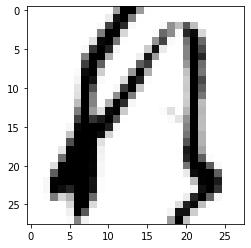

In [4]:
### TODO: visualize a sample image and corresponding label from KMNIST
def matplotlib_imshow(img):
    i, l = img
    i = i.mean(dim=0)
    npimg = i.numpy()
    plt.imshow(npimg, cmap="Greys")
    print(l)

matplotlib_imshow(kmnist_train_set[0])

## 1 Feed-forward Neural network
In this section, you will implement a simple feed-forward network from scratch. Follow the instructions/comments in each subsection to complete the general structure of the network.

### 1.1 Activation Functions (4 + 4 + 4 pts)
Implement [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function), [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) and [Identity](https://en.wikipedia.org/wiki/Identity_function) functions. This functions will later be used in network architecture.

In [5]:
def Sigmoid(x):
    """ Identity activation function
    Args:
        x (torch.tensor)
    Return:
        torch.tensor: a tensor of shape of x
    """
    # For some reason, this formula causes accuracy to suddenly drop around epoch 3, using torch for now..
    # return 1.0 / (1.0 +torch.exp(-x))
    return torch.sigmoid_(x)


def ReLU(x):
    """ ReLU activation function
    Args:
        x (torch.tensor)
    Return:
        torch.tensor: a tensor of shape of x
    """

    z = torch.zeros(x.size(), device='cuda')
    return torch.where(x > 0, x, z)

def Identity(x):
    """ Identity activation function
    Args:
        x (torch.tensor)
    Return:
        torch.tensor: a tensor of shape of x
    """
    return x

### 1.2 Cross Entropy Loss (7.5 + 7.5 pts)
Implement the Softmax function and Cross Entropy loss.

In [6]:
def Softmax(x,dim):
    """ Softmax function
    Args:torch.log(
        x (torch.tensor): inputs tensor of size (B,F)
        dim (int): A dimension along which Softmax will be computed
    Return:
        torch.tensor: a tensor of shape of x
    """
    mat = torch.nn.Softmax(dim)
    return mat(x)


def CE_loss(predictions,labels):
    """ Cross entropy loss
    Args:
        predictions (torch.tensor): tensor of shape of (B,C)
        labels (torch.tensor): tensor of shape of (B,1)
    Returns:
        torch.tensor: a tensor of shape of (1,)
    """

    ### TODO: Fill out this function
    loss = nn.CrossEntropyLoss().cuda()
    output = loss(predictions, labels)
    return output


### 1.3 Network (2.5 + 7.5 pts)
Complete the code for the simple feed-forward network shown below. 

Network parameters will be stored in a dictionary called `params`. weights and biases keys appear in the format `W#` and `b#` where `#` indicates the layer number. For example, the weights and biases of the first layer are `W1` and `b1`. Weights and biases are initialized inside `init_weights` function.

**Notes:** 
1. Set `requires_grad=True` when initializing weights and biases to have [pytorch automatic differentiation engine](https://pytorch.org/docs/stable/autograd.html) calculate the gradients.
2. Assign network parameters and inputs on the same `device`.
3. Initialize weights and biases with samples from normal distribution with mean 0 and variance 1.

In [7]:
params = {}

class my_nn:
    def __init__(self, layers_dim, layers_activation=None, device='cuda'):
        """ Initialize network
        Args:
            layers_dims (List of ints): list of Size of each layer of the network
                                        [inputs,layer1,...,outputs]
            layers_activation (List of strings): list of activation function for each hidden layer
                                        of the network[layer1,...,outputs]
            device (str): a device that will be used for computation
                Default: 'cpu'

        """
        self.layers_activation = layers_activation
        self.params = {}
        self.num_layers = len(layers_dim) - 1
        self.layers_dim = layers_dim
        self.device = device
        self.init_weights()

    def init_weights(self):
        """ Initialize weights and biases of network based on layers dimension.
            Store weights and biases in self.params.
            weights and biases key should be of format "W#" and "b#" where # is the layer number.
            Example: for layer 1, weight and bias key is "W1" and "b1"
        Args:
            None

        Returns:
            None
        """
        ### TODO: Initialize weights and bias of network
        ### TODO: Store weights and biases in self.params
        self.params = {
            'W1': torch.randn((784, 512), requires_grad=True, device="cuda"),
            'b1': torch.zeros((1, 512), requires_grad=True, device="cuda"),
            'W2': torch.randn((512, 512), requires_grad=True, device="cuda"),
            'b2': torch.zeros((1, 512), requires_grad=True, device="cuda"),
            'W3': torch.randn((512, 10), requires_grad=True, device="cuda"),
            'b3': torch.zeros((1, 10), requires_grad=True, device="cuda")
        }
        ### HINT: Remember to set require_grad to True
        ### HINT: Remember to put tensors of target device

    def forward(self, x):
        """ Perform forward pass
        Args:
            x (torch.tensor): tensor of shape of (B, C, H, W)

        Return:
            torch.tensor: tensor of shape of (B, N_classes)
        """
        ### TODO: Fill out this function
        x = torch.flatten(x, start_dim=1)
        x = torch.mm(x, self.params['W1'])
        x = x + self.params['b1']
        x = Sigmoid(x)

        x = torch.mm(x, self.params['W2'])
        x = x + self.params['b2']
        x = Sigmoid(x)

        x = torch.mm(x, self.params['W3'])
        x = x + self.params['b3']
        x = Sigmoid(x)

        return x


### 1.4 Training the network (12+12+6 pts)
Complete and run the following cells to train the network. You can use the predefined network hyper parameters or try your own.

In [8]:
def calc_accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return (classes == labels).float().sum()

def Train(model, optimizer, dataloader, device):
    """ performs training on train set
    Args:
        model (my_nn instance): model to be trained
        optimizer (torch.optim instance)
        dataloader (torch.utils.data.DataLoader instance): dataloader for train set
        device (str): computation device ['cpu','cuda',...]
    Returns:
        list of floats: mini_batch loss sampled every 20 steps for visualization purposes
        list of floats: mini_batch accuracy sampled every 20 steps for visualization purposes
    """
    loss_tracker = []
    accuracy_tracker = []
    for i, (data, label) in enumerate(dataloader):
        ### TODO: Put data and label on target device
        data = data.to(device).to(torch.float32)
        labels = label.to(device)
        ### TODO: Set gradients to zero
        optimizer.zero_grad()
        ### TODO: Pass data to the model
        out = model.forward(data)
        ### TODO: Calculate the loss of predicted labels vs ground truth labels
        loss = CE_loss(out, labels)
        ### TODO: Calculate gradients and update weights and biases
        loss.backward()
        optimizer.step()

        if i % 20:
            with torch.no_grad():
                loss_tracker.append(loss.item())
                ### TODO: calculate accuracy of mini_batch
                accuracy = calc_accuracy(out, labels)
                accuracy_tracker.append(accuracy / data.size(0))

    return loss_tracker, accuracy_tracker


def Test(model, dataloader, device):
    """ performs training on train set
    Args:
        model (my_nn instance): model to be trained
        dataloader (torch.utils.data.DataLoader instance)
        device (str): computation device ['cpu','cuda',...]
    Returns:
        floats: test set loss for visualization purposes
        floats: test set accuracy for visualization purposes
    """
    loss_tracker = []
    accuracy_tracker = []
    for i, (data, label) in enumerate(dataloader):
        ### TODO: Put data and label on target device
        data = data.to(device).to(torch.float32)
        labels = label.to(device)

        with torch.no_grad():
            ### TODO: Pass data to the model
            out = model.forward(data)
            ### TODO: Calculate the loss of predicted labels vs ground truth labels
            loss = CE_loss(out, labels)

            ### TODO: calculate accuracy of mini_batch
            accuracy = calc_accuracy(out, labels)

        loss_tracker.append(loss.item())
        accuracy_tracker.append(accuracy / data.size(0))

    return sum(loss_tracker) / len(loss_tracker), sum(accuracy_tracker) / len(accuracy_tracker)
        

In [9]:
# Training hyper parameters
epochs = 10
learning_rate = 0.001
layers_dim = [28*28,512,512,10]

### TODO: Set target device for computations
device = 'cuda'
print(f'device: {device}')

### TODO: Initialize model using layers_dim
model = my_nn(layers_dim, layers_activation='sigmoid', device=device)

### TODO: Initialize Adam optimizer
optimizer = torch.optim.Adam(model.params.values(), lr=learning_rate)

train_loss_tracker = []
train_accuracy_tracker = []

test_loss_tracker = []
test_accuracy_tracker = []

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    train_loss,train_accuracy = Train(model,optimizer,kmnist_train_loader,device)
    test_loss , test_accuracy = Test(model,kmnist_test_loader,device)
    train_loss_tracker.extend(train_loss)
    train_accuracy_tracker.extend(train_accuracy)
    test_loss_tracker.append(test_loss)
    test_accuracy_tracker.append(test_accuracy)
    print('\t training loss/accuracy: {0:.2f}/{1:.2f}'.format(sum(train_loss)/len(train_loss), sum(train_accuracy)/len((train_accuracy))))
    print('\t testing loss/accuracy: {0:.2f}/{1:.2f}'.format(test_loss, test_accuracy))

device: cuda
Epoch: 0
	 training loss/accuracy: 1.78/0.66
	 testing loss/accuracy: 1.83/0.62
Epoch: 1
	 training loss/accuracy: 1.64/0.81
	 testing loss/accuracy: 1.79/0.66
Epoch: 2
	 training loss/accuracy: 1.61/0.84
	 testing loss/accuracy: 1.76/0.69
Epoch: 3
	 training loss/accuracy: 1.59/0.86
	 testing loss/accuracy: 1.74/0.71
Epoch: 4
	 training loss/accuracy: 1.57/0.88
	 testing loss/accuracy: 1.71/0.73
Epoch: 5
	 training loss/accuracy: 1.56/0.89
	 testing loss/accuracy: 1.70/0.74
Epoch: 6
	 training loss/accuracy: 1.55/0.90
	 testing loss/accuracy: 1.69/0.75
Epoch: 7
	 training loss/accuracy: 1.55/0.91
	 testing loss/accuracy: 1.69/0.75
Epoch: 8
	 training loss/accuracy: 1.54/0.91
	 testing loss/accuracy: 1.68/0.77
Epoch: 9
	 training loss/accuracy: 1.54/0.92
	 testing loss/accuracy: 1.68/0.77


In [10]:
### TODO: visualize train_loss and train_accuracy
### TODO: visualize test_loss and test_accuracy


## 2 Convolutional Neural Network (CNN)

Implement a CNN and train your network. Using GPU will dramatically increase the training speed. If you are planning on using [Google Colab](https://colab.research.google.com/), one way to load the dataset is to load it from your google drive. Run the cell below to mount your google drive storage. If you are training on your local machine, comment out the following two lines.

In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

In this section, we will use the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/). You only need download [images](http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar) (Extract and upload this folder to your google drive if you are planning to use google colab). 

Run the cells below to load and visualize this dataset.

In [12]:
# load dataset from path
# set path to images location on your local machine or google drive
#path = 'drive/MyDrive/images/Images'  # Google drive
path = './images/Images'               #local machine
dataset = ImageFolder(path)
print(f'number of images: {len(dataset)}')
print(f'number of classes: {len(dataset.classes)}')

FileNotFoundError: [WinError 3] The system cannot find the path specified: './images/Images'

In [ ]:
# Create train and test splits of original dataset
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
train_size = len(dataset) - test_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

In [ ]:
# In order to apply transformations, we use a custom dataset
# see https://pytorch.org/docs/stable/data.html#iterable-style-datasets
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

In [ ]:
batch_size =64

#train set transforms
train_transform = transforms.Compose([
   transforms.Resize((240, 240)),
    transforms.ToTensor()    
])

# test set transforms
test_transform = transforms.Compose([
    transforms.Resize((240,240)), 
    transforms.ToTensor()
])

# Initialize train and test sets
train_dataset = DogBreedDataset(train_ds, train_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size)

In [ ]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break
show_batch(train_dl)